# This notebook is in progress and not meant to be a showpiece
I will update this notebook as I go, and will remove this notice from the top when it is complete

# Identifying Exoplanets using the TESS Objects of Interest Data Set
***Matt Paterson***<br>
***Machine Learning Engineer***<br>
***Santa Cruz, California***<br>

**Note about the Data**<br>
This data set is downloaded from the Cal Tech NASA Exoplanet Archive found <a href='https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=TOI'>here</a> and was downloaded on 2021-03-06 for the purpose of creating this instructional notebook.

**Note about the Spacecraft**<br>
TESS was launched by NASA in 2018 aboard a SpaceX rocket and completed its initial mission in July of 2020, poitively identifying 66 planets and recording over 2100 objects of interest. You can learn more about TESS <a href='https://exoplanets.nasa.gov/tess/'>here</a>

## The Data Science Problem
Can we use data from over 2000 observations made by the Transiting Exoplanet Survey Satellite (TESS) to positively identify more exoplanets in the sky using Machine Learning models?

## Import the necessary python libraries
In this notebook we will use python exclusively and in order to build our models, we'll utilize scikit-learn's libraries. This particular notebook will focus on the Logistic Regression model only.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
from sklearn.metrics         import plot_confusion_matrix

## Import your data
The data that we'll be using is already downloaded from CalTech/NASA, cleaned up a little for use here, and saved in a folder called 'data'. That 'data' folder lives in the same directory as a folder called 'code' where this notebook lives.

In order to import the data set, you'll have to provide the pandas function with a full datapath to find your csv file. You can choose to do this using the absolute path, which is recommended for production code, but for ease in this situation, you can go ahead and use the relative path.

In [2]:
datapath = '../data/'
filename = 'tess_oi.csv'

When you import the data set into a pandas DataFrame, go ahead and set the index column to 'rowid' using an argument in the pandas function. Then display 5 rows of data in your DataFrame.

In [3]:
df = pd.read_csv(datapath + filename, index_col='rowid')
df.sample(5)

,toi,toipfx,tid,ctoi_alias,pl_pnum,tfopwg_disp,rastr,ra,raerr1,raerr2,...,st_loggerr2,st_logglim,st_loggsymerr,st_rad,st_raderr1,st_raderr2,st_radlim,st_radsymerr,toi_created,rowupdate
rowid,,,,,,,,,,,,,,,,,,,,,
517,1446.01,1446,294471966,294471966.0,1,PC,20h08m00.35s,302.001457,NaN,NaN,...,-0.076594,0,1,0.830310,0.039874,-0.039874,0,1,11/14/2019 17:07,10/30/2020 1:59
101,1090.01,1090,361034196,361034196.0,1,FP,16h08m03.92s,242.016315,NaN,NaN,...,-0.610000,0,1,2.950000,0.160000,-0.160000,0,1,8/6/2019 19:30,12/17/2019 10:00
1185,2025.01,2025,394050135,394050135.0,1,PC,18h51m10.86s,282.795256,NaN,NaN,...,-0.080000,0,1,1.480000,0.070000,-0.070000,0,1,6/19/2020 7:20,11/17/2020 12:00
660,1572.01,1572,292321872,292321872.0,1,FP,02h07m36.53s,31.902189,NaN,NaN,...,-0.090000,0,1,2.520000,0.170000,-0.170000,0,1,12/19/2019 20:58,3/4/2020 12:58
280,1245.01,1245,229781583,229781583.0,1,PC,18h54m08.53s,283.535530,NaN,NaN,...,-0.008825,0,1,0.524555,0.015499,-0.015499,0,1,10/17/2019 0:30,10/30/2020 1:59


How many rows and columns of data do you have in this data set? How many null values do you have in each column? Are the data types in the table logical and ready for modeling? Why or why not? What are some different python or pandas or matplotlib functions that you can use to inspect this data?

In [4]:
df.shape

(2542, 86)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2542 entries, 1 to 2542
Data columns (total 86 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   toi                2542 non-null   float64
 1   toipfx             2542 non-null   int64  
 2   tid                2542 non-null   int64  
 3   ctoi_alias         2542 non-null   float64
 4   pl_pnum            2542 non-null   int64  
 5   tfopwg_disp        2535 non-null   object 
 6   rastr              2542 non-null   object 
 7   ra                 2542 non-null   float64
 8   raerr1             0 non-null      float64
 9   raerr2             0 non-null      float64
 10  decstr             2542 non-null   object 
 11  dec                2542 non-null   float64
 12  decerr1            0 non-null      float64
 13  decerr2            0 non-null      float64
 14  st_pmra            2526 non-null   float64
 15  st_pmraerr1        2526 non-null   float64
 16  st_pmraerr2        2526 

In [6]:
df.isna().sum()

toi               0
toipfx            0
tid               0
ctoi_alias        0
pl_pnum           0
               ... 
st_raderr2      403
st_radlim         0
st_radsymerr      0
toi_created       0
rowupdate         0
Length: 86, dtype: int64

## Quick and dirty data cleaning
With any dataset, you'll want to spend lots of time looking at each and every column of data and learning what each is and how it relates to the other columns. You'll employ correlation matrices, scatterplots, and bar charts to see patterns. You'll have to impute missing data and decide if some data can be imputed at all. You'll have to engineer data columns and aggregate data columns and convert columns to different units of measurement. 

This particular notebook is intended to help you learn how to use the Logistic Regression Classification Model, so rather than spend all of our time on the data (a typical Data Scientist spends most of their time acquiring, cleaning, and maintaining their data), we're going to make what I like to call the 'Quick and Dirty Model' by dropping all columns with null values.

## Drop all null values
Use a pandas method to drop all of the columns in your table that contain null values, and save this new dataframe to a variable called 'tess', and then print the number of rows and columns that the new 'tess' DataFrame contains.

In [7]:
tess = df.dropna(axis=1)
tess.shape

(2542, 37)

## Add back our target column
One of the columns that we dropped is actually VERY important to our model. df['tfopwg_disp'] is actually going to be our TARGET column, or the column that we're going to use for classification.

Use pd.merge() to add that column back on to our table, minding the index so that we don't switch anything around and completely break our model before we build it.

In [8]:
tess = pd.merge(tess, df['tfopwg_disp'], how='outer', left_index=True, right_index=True)

In [9]:
tess.shape

(2542, 38)

How many of your new columns are non-numeric?

In [10]:
tess.dtypes

toi                  float64
toipfx                 int64
tid                    int64
ctoi_alias           float64
pl_pnum                int64
rastr                 object
ra                   float64
decstr                object
dec                  float64
pl_tranmid           float64
pl_tranmidlim          int64
pl_tranmidsymerr       int64
pl_orbperlim           int64
pl_orbpersymerr        int64
pl_trandurh          float64
pl_trandurhlim         int64
pl_trandurhsymerr      int64
pl_trandep           float64
pl_trandeplim          int64
pl_trandepsymerr       int64
pl_radelim             int64
pl_radesymerr          int64
st_tmag              float64
st_tmagerr1          float64
st_tmagerr2          float64
st_tmaglim             int64
st_tmagsymerr          int64
st_distlim             int64
st_distsymerr          int64
st_tefflim             int64
st_teffsymerr          int64
st_logglim             int64
st_loggsymerr          int64
st_radlim              int64
st_radsymerr  

In [11]:
type(tess.dtypes)

pandas.core.series.Series

Calling the DataFrame's dtypes attribute returns a pandas Series, list-like object, the values of which are all strings displaying the datatype of each column in your DataFrame. Can you figure out a way to display the names of just the columns that are non-numeric?

In [12]:
# HINT: You can see the index of each row of a pandas Series in the
# same way that you list the index of each row in a pandas DataFrame
tess.dtypes.index

Index(['toi', 'toipfx', 'tid', 'ctoi_alias', 'pl_pnum', 'rastr', 'ra',
       'decstr', 'dec', 'pl_tranmid', 'pl_tranmidlim', 'pl_tranmidsymerr',
       'pl_orbperlim', 'pl_orbpersymerr', 'pl_trandurh', 'pl_trandurhlim',
       'pl_trandurhsymerr', 'pl_trandep', 'pl_trandeplim', 'pl_trandepsymerr',
       'pl_radelim', 'pl_radesymerr', 'st_tmag', 'st_tmagerr1', 'st_tmagerr2',
       'st_tmaglim', 'st_tmagsymerr', 'st_distlim', 'st_distsymerr',
       'st_tefflim', 'st_teffsymerr', 'st_logglim', 'st_loggsymerr',
       'st_radlim', 'st_radsymerr', 'toi_created', 'rowupdate', 'tfopwg_disp'],
      dtype='object')

If you want a short-cut, you can always just manually copy/paste the non-numeric column names, but that's not really a shortcut option when you have more than four non-numeric columns.

In [13]:
#create an empty dictionary for your dtypes
dtype_dict = {}

#iterate through the Series of tess.dtypes and 
#create your dictionary using the tess.dtypes.index Series as keys
for i in range(len(tess.dtypes)):
    dtype_dict[tess.dtypes.index[i]] = tess.dtypes[i]

for key in dtype_dict:
    if dtype_dict[key] == 'object':
        print(key)

rastr
decstr
toi_created
rowupdate
tfopwg_disp


## Data Engineering
What are these non-numeric columns? Are they important to our model? If so, how can we make them into numeric columns? 

There is a data dictionary in the data folder where we got the data set, and it should be helpful here. For more detailed information you can follow the link to the data set above and click on the "view documentation" button to see what these are.

[Hide This block] The 'rastr' and 'decstr' are fields for the location of the objects in the sky relative to earth, also known as the Right Acension and Declination. These columns are actually duplicated in the data because the 'ra' and 'dec' columns convert these stellar addresses to decimal degrees, allowing us to use them in the model (or even to map the sky).

In [14]:
tess['toi_created'].sample(5)

rowid
1666     2/3/2021 22:59
111      9/5/2018 18:34
1124    6/17/2020 17:40
49      6/25/2019 15:58
2227    4/30/2019 13:04
Name: toi_created, dtype: object

In [15]:
tess['rowupdate'].sample(5)

rowid
310     12/18/2020 12:01
702      9/11/2020 16:00
344      9/23/2020 16:00
580      2/19/2021 16:00
2071     2/18/2021 16:00
Name: rowupdate, dtype: object

[Hide This block] The 'toi_created' and 'rowupdate' fields are both dates and times when there were updates to the data table, one being the original discovery of the object of interest and the other being the last time information was added to the table in that row. 

## Drop these columns
We want to keep the 'tfopwg_disp' column as this will be our target column for our model, but we can drop the other four columns. 

We can drop them using the pd.DataFrame.drop() method, and we can make that permanent by dropping them "inplace" as we do.

In [16]:
tess.drop(columns=['rastr', 'decstr', 'toi_created', 'rowupdate'], inplace=True)

In [17]:
tess.shape

(2542, 34)

## What are we even predicting here?
We want to know if the dataset itself can help point out likely planetary candidates. To do this, we want to see what objects have already been identified by the CalTech and NASA scientists, and then infer commonalities in the data using Logistic Regression to classify the unclassified data points.

This means we'll want to convert the classifications that we have into a binary set of positive and negatively identified planets. Given the nature of our data set, there will be a third category of "unclassified" data, which is what we'll deploy our model on once it is trainied. Sounds easy, right?

### This key explains the basic classifications:
 	TESS Follow-up Observing Program Working Group (TFOPWG) Dispostion:

- CP=confirmed planet
- KP=known planet
- FP=false positive
- PC=planetary candidate 

# warning - this might confuse you

The term "False Positive" will be used by us, Data Scientists and Machine Learning Engineers, to identify an observation that our model predicts should be a "Positive" but that the ground truth tells is was a "Negative". Since we **predicted** this to be "Positive" and we were wrong, this is known as a "False Positive".

The TESS Objects of Interest table was/is built by Scientists who have a good reason to think that these objects are good candidates to be exoplanets. As such, if it turns out that through further investigation that one of these observations is not in fact an exoplanet, they classify that as a "false positive". We're going to convert that classification to a simple negative designation.

For ease of understanding, we'll create a mapping function to convert our designations to either 1 for exoplanet, 0 for not-exoplanet, or 2 for 'unclassified'.

In [18]:
tess.tfopwg_disp.value_counts(normalize=True)

PC     0.560552
FP     0.181854
KP     0.112426
APC    0.076529
CP     0.053254
FA     0.015385
Name: tfopwg_disp, dtype: float64

In [19]:
# create a dict that maps the classifications in TOI 
# to the classifications that we'll use for modeling

class_map = {
    'PC':2,
    'FP':0,
    'KP':1,
    'APC':2,
    'CP':1,
    'FA':0
}

In [20]:
tess['target'] = tess['tfopwg_disp'].map(class_map)

We also know that there are null fields in the target column. Since we know that no other fields are null in our dataframe, we can use the pd.DataFrame.fillna() funciton to change those NaN values to 'unclassified', or 2.

In [21]:
tess = tess.fillna(2)

Now we can look at our baseline model numbers

In [22]:
tess.target.value_counts(normalize=True)

2.0    0.638080
0.0    0.196696
1.0    0.165224
Name: target, dtype: float64

From our original data set, 63.8% of the data are unclassified, 19.7% of the data are negatively classified, and 16.5% are positively classified.

To train the model, we'll split off the unclassified data so that we're only training on classified data.

In [23]:
tess_model = tess[tess['target'] != 2]
tess_model.target.value_counts(normalize=True)

0.0    0.543478
1.0    0.456522
Name: target, dtype: float64

So this baseline score of 54.3% is what our model has to beat. If our we guessed that every object we saw was a planet, we'd be wrong 54.3% of the time (and a converse hypothesis would result in that maximum rate).

## Train Test Split
We'll want to do more feature engineering to our dataset, but before we do, let's put down a couple of baselines by which to measure our progress. To do that, we're going to first see the distribution of the classfications in our target column, and then we'll use train_test_split to break up our data set into a training set and a testing set

In [24]:
tess_model = tess_model.drop(columns='tfopwg_disp')
tess_model.shape

(920, 34)

In [25]:
# Create your X matrix and y vector
X = tess_model.drop(columns='target')
y = tess_model['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.2, 
                                                    random_state=42)

## Model Time!!
Instantiate a Logistic Regression Model and print out your training, testing, and overall accuracy scores.


In [26]:
model = LogisticRegression()
model.fit(X_train, y_train)
print('Training Accuracy Score : ', model.score(X_train, y_train))
print('Testing Accuracy Score  : ', model.score(X_test, y_test))
print('Overall Accuracy Score  : ', model.score(X, y))

Training Accuracy Score :  0.5652173913043478
Testing Accuracy Score  :  0.47282608695652173
Overall Accuracy Score  :  0.5467391304347826


## How did we do? 
Recall that our baseline model, or the basic split between our binary classification classes, was 54%. Was our Quick and Dirty model an improvement over our baseline? Why or why not?

[Hide this] No it was not. Our model performed about the same as the baseline model.

Is our Model well-fit? Is it showing signs of bias? Is it overfit? Why or why not?

## Scale our data
Using Standard Scaler to scale our data, we can bring our data in to a more readable place where our model can be better trained on the data and less sensitive to differences in numeric scale or measure.

To better understand StandardScaler, and to help you use it, it's a good idea to check out the documentation <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html'>here</a><br>
Note: Some code in this section borrowed from Tim Book and Matt Brems

In [27]:
sc = StandardScaler()

In [28]:
# Scale our data.
# Relabeling scaled data as "Z" is common.
Z_train = sc.fit_transform(X_train)
# DO NOT use 'fit' on your test data
Z_test = sc.transform(X_test)

In [29]:
print(f'Z_train shape is: {Z_train.shape}')
print(f'y_train shape is: {y_train.shape}')
print(f'Z_test shape is: {Z_test.shape}')
print(f'y_test shape is: {y_test.shape}')

Z_train shape is: (736, 33)
y_train shape is: (736,)
Z_test shape is: (184, 33)
y_test shape is: (184,)


Now let's try running the scaled data through a new Logistic Regression model

In [30]:
model_1 = LogisticRegression()
model_1.fit(Z_train, y_train)
print('Training Accuracy Score : ', model_1.score(Z_train, y_train))
print('Testing Accuracy Score  : ', model_1.score(Z_test, y_test))


Training Accuracy Score :  0.7078804347826086
Testing Accuracy Score  :  0.6195652173913043


## Holy Smokes!
we just improved our accuracy by 50%! Why is that?

[Hide this] It's because we scaled the data so that the model wouldn't be confused by the drastically different numerical scales

## What does the confusion matrix tell us?

In [31]:
# Scale the X matrix into a Z matrix
Z = sc.transform(X)

# Show the predictions that the model makes on Z
y_pred = model_1.predict(Z)

# Evaluate the confusion matrix
confusion_matrix(y_true=y, y_pred=y_pred)

array([[411,  89],
       [196, 224]], dtype=int64)

## Plot the confusion matrix into a visualization

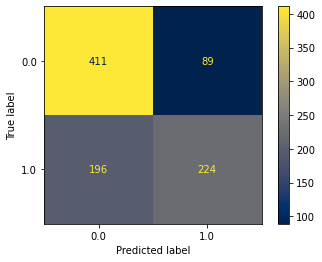

In [32]:

plot_confusion_matrix(model_1, Z, y, cmap='cividis')  
plt.show()  


What does the Confusion Matrix tell us?

[Hide this] We have 224 true positives and 89 false positives. We have 411 true negatives and 196 false negatives. That means that we erroneously classified 196 exoplanets as 'not-exoplanets'. Think of all the vacations that will never happen to those undiscovered planets if we didn't realize they were there. It also means that we classified 89 objects as 'exoplanets' when they were actually 'not-exoplanets'. That's a lot of rocket fuel to take us to nowhwere...

What are the following values:

Sensitivity (explain and compute)

Recall (explain and compute)

Specificity (explain and compute)

Misclassification Rate (explain and compute)

Precision (explain and compute)

Is our model well-fit? Does it appear to show bias or over-fitting?

[Hide this] It's overfit

What kinds of things might we do to improve our model?

[Hide this] We can go through each of the features and examine what each one is. Are the numbers Cardinal or Ordinal? Should we actually one-hot-encode any of those fields? Are columns such as 'ra' and 'dec' useful to our model? If this were an unsupervised clustering algorithm, 'ra' and 'dec' might be very useful. However in this case, since they are addresses rather than units of measure, they may or may not help the LogisticRegression model. That's just one example.

[Hide this] We can also see if there is more data. As it stands, we're trying to train a model on less than 1,000 rows of data. That's not a lot of data. We'll have much better luck building a model with ten or a hundred times that amount of data.

Should we call CalTech and NASA and tell them that we figured out which objects on the TESS Objects of Interest data set are Exoplanets?

[Hide this] No we should not. Our model only has a testing score of 62%, which while that is better than the  baseline, it is still not likely to be an improvement on the current solution being employed. We need to go through our data set and greatly improve our accuracy if we want to share our model with industry, clients, or superiors.

[Hide this] In many cases, the data that we'll find or acquire in the real world are incomplete, unreliable, or not very good at helping us predict results. In some cases 62% is the best accuracy that you can hope for. However, if you don't try to investigate every column in your dataset, you won't know for sure if you have the best possible model.

## Make Predictions
This is it, the moment you've been waiting for...time to make predictions on the unclassfied data